In [4]:
import keras 
import keras_genomics
import numpy as np
import keras.layers as k1

from keras import backend as K 
from keras.layers.core import Dropout 
from keras.layers.core import Flatten
from keras.layers import Input
from keras.engine import Layer
from keras.models import Sequential 
from keras.engine.base_layer import InputSpec
from keras.models import Model
from keras.models import load_model

In [5]:
from keras.initializers import Initializer
def _compute_fans(shape, data_format='channels_last'):
    """Computes the number of input and output units for a weight shape.
    # Arguments
        shape: Integer shape tuple.
        data_format: Image data format to use for convolution kernels.
            Note that all kernels in Keras are standardized on the
            `channels_last` ordering (even when inputs are set
            to `channels_first`).
    # Returns
        A tuple of scalars, `(fan_in, fan_out)`.
    # Raises
        ValueError: in case of invalid `data_format` argument.
    """
    if len(shape) == 2:
        fan_in = shape[0]
        fan_out = shape[1]
    elif len(shape) in {3, 4, 5}:
        # Assuming convolution kernels (1D, 2D or 3D).
        # TH kernel shape: (depth, input_depth, ...)
        # TF kernel shape: (..., input_depth, depth)
        if data_format == 'channels_first':
            receptive_field_size = np.prod(shape[2:])
            fan_in = shape[1] * receptive_field_size
            fan_out = shape[0] * receptive_field_size
        elif data_format == 'channels_last':
            receptive_field_size = np.prod(shape[:-2])
            fan_in = shape[-2] * receptive_field_size
            fan_out = shape[-1] * receptive_field_size
        else:
            raise ValueError('Invalid data_format: ' + data_format)
    else:
        # No specific assumptions.
        fan_in = np.sqrt(np.prod(shape))
        fan_out = np.sqrt(np.prod(shape))
    return fan_in, fan_out

class RevcompVarianceScaling(Initializer):
    def __init__(self, scale=1.0,
                 mode='fan_in',
                 distribution='normal',
                 seed=None):
        if scale <= 0.:
            raise ValueError('`scale` must be a positive float. Got:', scale)
        mode = mode.lower()
        if mode not in {'fan_in', 'fan_out', 'fan_avg'}:
            raise ValueError('Invalid `mode` argument: '
                             'expected on of {"fan_in", "fan_out", "fan_avg"} '
                             'but got', mode)
        distribution = distribution.lower()
        if distribution not in {'normal', 'uniform'}:
            raise ValueError('Invalid `distribution` argument: '
                             'expected one of {"normal", "uniform"} '
                             'but got', distribution)
        self.scale = scale
        self.mode = mode
        self.distribution = distribution
        self.seed = seed

    def __call__(self, shape, dtype=None):
        fan_in, fan_out = _compute_fans(shape)
        fan_out = fan_out*2 #revcomp kernel underestimates fan_out
        print("fanin:",fan_in, "fanout:",fan_out, self.scale, self.mode)
        scale = self.scale
        if self.mode == 'fan_in':
            scale /= max(1., fan_in)
        elif self.mode == 'fan_out':
            scale /= max(1., fan_out)
        else:
            scale /= max(1., float(fan_in + fan_out) / 2)
        if self.distribution == 'normal':
            # 0.879... = scipy.stats.truncnorm.std(a=-2, b=2, loc=0., scale=1.)
            stddev = np.sqrt(scale) / .87962566103423978
            return K.truncated_normal(shape, 0., stddev,
                                      dtype=dtype, seed=self.seed)
        else:
            limit = np.sqrt(3. * scale)
            return K.random_uniform(shape, -limit, limit,
                                    dtype=dtype, seed=self.seed)

    def get_config(self):
        return {
            'scale': self.scale,
            'mode': self.mode,
            'distribution': self.distribution,
            'seed': self.seed
        }

In [13]:
from seqdataloader.batchproducers import coordbased
import gzip
import numpy as np

class ColsInBedFile(
    coordbased.coordstovals.core.AbstractSingleNdarrayCoordsToVals):
    def __init__(self, gzipped_bed_file, **kwargs):
        super(ColsInBedFile, self).__init__(**kwargs)
        self.gzipped_bed_file = gzipped_bed_file
        coords_to_vals = {}
        for row in gzip.open(gzipped_bed_file, 'rb'):
            row = row.decode("utf-8").rstrip()
            split_row = row.split("\t")
            chrom_start_end = split_row[0]+":"+split_row[1]+"-"+split_row[2]
            vals = np.array([float(x) for x in split_row[4:]])
            coords_to_vals[chrom_start_end] = vals
        self.coords_to_vals = coords_to_vals
        
    def _get_ndarray(self, coors):
        to_return = []
        for coor in coors:
            chrom_start_end = (coor.chrom+":"
                               +str(coor.start)+"-"+str(coor.end))
            to_return.append(self.coords_to_vals[chrom_start_end])
        return np.array(to_return)
    

inputs_coordstovals = coordbased.coordstovals.fasta.PyfaidxCoordsToVals(
  genome_fasta_path='/mnt/data/annotations/by_release/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta',
  center_size_to_use=1000)

targets_coordstovals = ColsInBedFile(
       gzipped_bed_file="summits_with_signal.bed.gz")

keras_test_batch_generator = coordbased.core.KerasBatchGenerator(
    coordsbatch_producer = coordbased.coordbatchproducers.SimpleCoordsBatchProducer(
        bed_file="test_summits_with_signal.bed.gz",
        coord_batch_transformer=coordbased.coordbatchtransformers.ReverseComplementAugmenter(),
        batch_size = 64, 
        shuffle_before_epoch = True, 
        seed = 1234
    ), 
    inputs_coordstovals = inputs_coordstovals, 
    targets_coordstovals = targets_coordstovals
)

keras_test_batch_generator_augment = coordbased.core.KerasBatchGenerator(
    coordsbatch_producer = coordbased.coordbatchproducers.SimpleCoordsBatchProducer(
        bed_file="test_summits_with_signal.bed.gz",
        coord_batch_transformer=coordbased.coordbatchtransformers.ReverseComplementAugmenter(),
        batch_size = 128, 
        shuffle_before_epoch = True, 
        seed = 1234
    ), 
    inputs_coordstovals = inputs_coordstovals, 
    targets_coordstovals = targets_coordstovals
)

In [7]:
class RevCompSumPool(Layer): 
    def __init__(self, **kwargs): 
        super(RevCompSumPool, self).__init__(**kwargs)

    def build(self, input_shape):
        self.num_input_chan = input_shape[2]
        super(RevCompSumPool, self).build(input_shape)

    def call(self, inputs): 
        #divide by sqrt 2 for variance preservation
        inputs = (inputs[:,:,:int(self.num_input_chan/2)] + inputs[:,:,int(self.num_input_chan/2):][:,::-1,::-1])/(1.41421356237)
        return inputs
      
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], int(input_shape[2]/2))


In [8]:
class RevCompSpatialDropout1D(Dropout): 
    def __init__(self, rate,**kwargs): 
        super(RevCompSpatialDropout1D, self).__init__(rate, **kwargs)
        self.seed = 3
        self.input_spec = InputSpec(ndim = 3)

    def _get_noise_shape(self, inputs): 
        input_shape = K.shape(inputs)
        noise_shape = (input_shape[0], 1, 1, int(self.num_input_chan/2)) 
        return noise_shape
        
    def build(self, input_shape):
        self.num_input_chan = input_shape[2]
        self.input_len = input_shape[1]
        super(RevCompSpatialDropout1D, self).build(input_shape)

    def call(self, inputs, training=None): 
        inputs_fwdandrevconcat = K.concatenate(
                tensors = [
                    inputs[:,:,None,:int(self.num_input_chan/2)],
                    inputs[:,:,None,int(self.num_input_chan/2):][:,:,:,::-1]],
                axis=2)

        if 0. < self.rate < 1.: 
            noise_shape = self._get_noise_shape(inputs)
            def dropped_inputs(): 
                dropped = K.dropout(inputs_fwdandrevconcat,
                                    self.rate, noise_shape, seed = self.seed)
                dropped = K.reshape(dropped, (-1, int(self.input_len), int(self.num_input_chan)))
                return K.concatenate(
                    tensors = [
                        dropped[:,:,:int(self.num_input_chan/2)],
                        dropped[:,:,int(self.num_input_chan/2):][:,:,::-1]],
                    axis=-1)

            return K.in_train_phase(dropped_inputs, inputs, training = training)

        return inputs

In [9]:
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import random_ops
from tensorflow.python.framework import tensor_shape
from tensorflow.python.ops import array_ops
from tensorflow.python.framework import ops
import numbers
from tensorflow.python.framework import tensor_util
def _get_noise_shape(x, noise_shape):
  # If noise_shape is none return immediately.
  if noise_shape is None:
    return array_ops.shape(x)

  try:
    # Best effort to figure out the intended shape.
    # If not possible, let the op to handle it.
    # In eager mode exception will show up.
    noise_shape_ = tensor_shape.as_shape(noise_shape)
  except (TypeError, ValueError):
    return noise_shape

  if x.shape.dims is not None and len(x.shape.dims) == len(noise_shape_.dims):
    new_dims = []
    for i, dim in enumerate(x.shape.dims):
      if noise_shape_.dims[i].value is None and dim.value is not None:
        new_dims.append(dim.value)
      else:
        new_dims.append(noise_shape_.dims[i].value)
    return tensor_shape.TensorShape(new_dims)

  return noise_shape

class MCRCDropout(Layer):
    """Applies MC Dropout to the input.
       The applied noise vector is symmetric to reverse complement symmetry
       Class structure only slightly adapted 
    Dropout consists in randomly setting
    a fraction `rate` of input units to 0 at each update during training time,
    which helps prevent overfitting.
    Remains active ative at test time so sampling is required
    # Arguments
        rate: float between 0 and 1. Fraction of the input units to drop.
        noise_shape: 1D integer tensor representing the shape of the
            binary dropout mask that will be multiplied with the input.
            For instance, if your inputs have shape
            `(batch_size, timesteps, features)` and
            you want the dropout mask to be the same for all timesteps,
            you can use `noise_shape=(batch_size, 1, features)`.
        seed: A Python integer to use as random seed.
    # References
        - [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](http://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf)
    """
    def __init__(self, rate, noise_shape=None, seed=None, **kwargs):
        super(MCRCDropout, self).__init__(**kwargs)
        self.rate = min(1., max(0., rate))
        self.noise_shape = noise_shape
        self.seed = seed
        self.supports_masking = True
        
    def build(self, input_shape):
        self.num_input_chan = input_shape[2]
        super(MCRCDropout, self).build(input_shape)

    def _get_noise_shape(self, inputs):
        if self.noise_shape is None:
            return self.noise_shape

        symbolic_shape = K.shape(inputs)
        noise_shape = [symbolic_shape[axis] if shape is None else shape
                       for axis, shape in enumerate(self.noise_shape)]
        return tuple(noise_shape)

    def call(self, inputs, training=None):
        if 0. < self.rate < 1.:
            import numpy as np
            noise_shape = self._get_noise_shape(inputs)
            x = inputs
            seed = self.seed
            keep_prob = 1. - self.rate
            if seed is None:
                seed = np.random.randint(10e6)
            # the dummy 1. works around a TF bug
            # (float32_ref vs. float32 incompatibility)
            x= x*1
            name = None
            with ops.name_scope(name, "dropout", [x]) as name:
                x = ops.convert_to_tensor(x, name="x")
                if not x.dtype.is_floating:
                    raise ValueError("x has to be a floating point tensor since it's going to"
                       " be scaled. Got a %s tensor instead." % x.dtype)
                if isinstance(keep_prob, numbers.Real) and not 0 < keep_prob <= 1:
                    raise ValueError("keep_prob must be a scalar tensor or a float in the "
                       "range (0, 1], got %g" % keep_prob)
                keep_prob = ops.convert_to_tensor(
                             keep_prob, dtype=x.dtype, name="keep_prob")
                keep_prob.get_shape().assert_is_compatible_with(tensor_shape.scalar())

                # Do nothing if we know keep_prob == 1
                if tensor_util.constant_value(keep_prob) == 1:
                    return x

                noise_shape = _get_noise_shape(x, noise_shape)
                # uniform [keep_prob, 1.0 + keep_prob)
                random_tensor = keep_prob
                random_tensor += random_ops.random_uniform(
                noise_shape, seed=seed, dtype=x.dtype)
               
                # 0. if [keep_prob, 1.0) and 1. if [1.0, 1.0 + keep_prob)
                binary_tensor = math_ops.floor(random_tensor)
                dim = binary_tensor.shape[2]//2

                symmetric_binary = K.concatenate(
                    tensors = [
                      binary_tensor[:,:,int(self.num_input_chan/2):], 
                      binary_tensor[:,:,int(self.num_input_chan/2):][::,::-1,::-1]], 
                  axis=2)
                ret = math_ops.div(x, keep_prob) * symmetric_binary
                
                return ret


    def get_config(self):
        config = {'rate': self.rate,
                  'noise_shape': self.noise_shape,
                  'seed': self.seed}
        base_config = super(MCRCDropout, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

In [10]:
custom_objects = {'RevCompConv1D':keras_genomics.layers.RevCompConv1D,
                  'RevCompSumPool':RevCompSumPool,
                  'RevcompVarianceScaling':RevcompVarianceScaling, 
                  'MCRCDropout':MCRCDropout,
                  'RevCompSpatialDropout1D': RevCompSpatialDropout1D}
rc_var_model_final = load_model('rc_var_1000.h5', custom_objects)
rc_standard_model_final = load_model('rc_standard_1000.h5', custom_objects)
rc_standard_model_dropout = load_model('rc_standard_dropout_1000.h5', custom_objects)
rc_standard_model_mcdropout = load_model('rc_standard_mcdropout_1000.h5', custom_objects)
rc_standard_model_spatial_dropout = load_model('rc_standard_spatial_dropout_1000.h5', custom_objects)
reg_dropout = load_model('reg_dropout_1000.h5', custom_objects) 
augment_dropout = load_model('augment_dropout_1000.h5', custom_objects)

W0717 09:31:49.609311 140631510681344 deprecation_wrapper.py:119] From /users/hannahgz/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0717 09:31:49.642057 140631510681344 deprecation_wrapper.py:119] From /users/hannahgz/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0717 09:31:49.709361 140631510681344 deprecation_wrapper.py:119] From /users/hannahgz/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0717 09:31:49.751358 140631510681344 deprecation_wrapper.py:119] From /users/hannahgz/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session 

fanin: 60 fanout: 450 1.0 fan_avg


W0717 09:31:53.452966 140631510681344 deprecation_wrapper.py:119] From /users/hannahgz/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0717 09:31:54.876938 140631510681344 deprecation.py:506] From /users/hannahgz/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0717 09:31:56.709369 140631510681344 deprecation.py:323] From <ipython-input-9-2e0460397d71>:116: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [11]:
class RevComp(Layer): 
    def __init__(self, **kwargs): 
      super(RevComp, self).__init__(**kwargs)

    def build(self, input_shape):
      super(RevComp, self).build(input_shape)

    def call(self, inputs): 
      return inputs[:,::-1,::-1]
      
    def compute_output_shape(self, input_shape):
      return input_shape
custom_objects = {'RevComp':RevComp}
siamese_model_final = load_model('siamese_1000.h5', custom_objects)

In [10]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [20]:
y_pred_var = rc_var_model_final.predict_generator(keras_test_batch_generator)
y_test = np.array([val for batch in keras_test_batch_generator for val in batch[1]], dtype = 'float32') 

In [1]:
y_pred_standard = rc_standard_model_final.predict_generator(keras_test_batch_generator)

NameError: name 'rc_standard_model_final' is not defined

In [13]:
y_pred_siamese = siamese_model_final.predict_generator(keras_test_batch_generator)

In [12]:
y_pred_rc_dropout = rc_standard_model_dropout.predict_generator(keras_test_batch_generator)
y_pred_rc_mcdropout = rc_standard_model_mcdropout.predict_generator(keras_test_batch_generator)
y_pred_rc_spatial_dropout = rc_standard_model_spatial_dropout.predict_generator(keras_test_batch_generator)
y_pred_reg_dropout = reg_dropout.predict_generator(keras_test_batch_generator)

NameError: name 'keras_test_batch_generator_augment' is not defined

In [14]:
y_pred_augment_dropout = augment_dropout.predict_generator(keras_test_batch_generator_augment)

In [21]:
from matplotlib import pyplot as plt
from scipy.stats import spearmanr

plt.scatter(y_test, y_pred_standard, alpha = 0.1)
plt.xlabel("True Labels: RC Standard Initialization")
plt.ylabel("Predicted Labels")
plt.show()
print(spearmanr(y_test, y_pred_standard))

plt.scatter(y_test, y_pred_var, alpha = 0.1)
plt.xlabel("True Labels: RC Variance Initialization")
plt.ylabel("Predicted Labels")
# plt.plot([np.min(y_test), np.max(y_test)],
#          [np.min(y_pred), np.max(y_test)],
#           color="black")
plt.show()
print(spearmanr(y_test, y_pred_var))

plt.scatter(y_test, y_pred_siamese, alpha = 0.1)
plt.xlabel("True Labels: Siamese Model")
plt.ylabel("Predicted Labels")
# plt.plot([np.min(y_test), np.max(y_test)],
#          [np.min(y_pred), np.max(y_test)],
#           color="black")
plt.show()
print(spearmanr(y_test, y_pred_siamese))

NameError: name 'y_pred_standard' is not defined

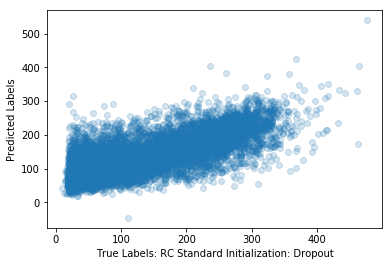

SpearmanrResult(correlation=0.681162555303287, pvalue=0.0)


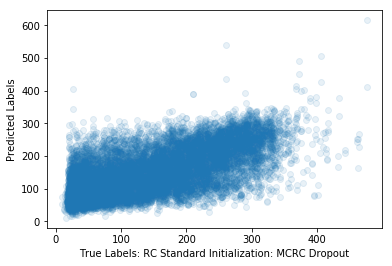

SpearmanrResult(correlation=0.6486953262330768, pvalue=0.0)


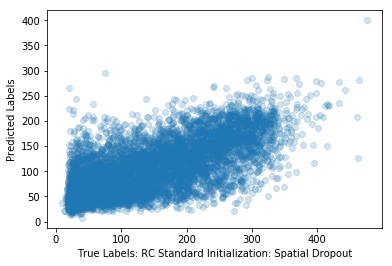

SpearmanrResult(correlation=0.6832397777105094, pvalue=0.0)


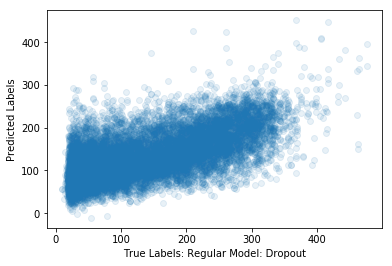

SpearmanrResult(correlation=0.6225196856926347, pvalue=0.0)


In [18]:
plt.scatter(y_test, y_pred_rc_dropout, alpha = 0.1)
plt.xlabel("True Labels: RC Standard Initialization: Dropout")
plt.ylabel("Predicted Labels")
plt.show()
print(spearmanr(y_test, y_pred_rc_dropout))

plt.scatter(y_test, y_pred_rc_mcdropout, alpha = 0.1)
plt.xlabel("True Labels: RC Standard Initialization: MCRC Dropout")
plt.ylabel("Predicted Labels")
# plt.plot([np.min(y_test), np.max(y_test)],
#          [np.min(y_pred), np.max(y_test)],
#           color="black")
plt.show()
print(spearmanr(y_test, y_pred_rc_mcdropout))

plt.scatter(y_test, y_pred_rc_spatial_dropout, alpha = 0.1)
plt.xlabel("True Labels: RC Standard Initialization: Spatial Dropout")
plt.ylabel("Predicted Labels")
# plt.plot([np.min(y_test), np.max(y_test)],
#          [np.min(y_pred), np.max(y_test)],
#           color="black")
plt.show()
print(spearmanr(y_test, y_pred_rc_spatial_dropout))


plt.scatter(y_test, y_pred_reg_dropout, alpha = 0.1)
plt.xlabel("True Labels: Regular Model: Dropout")
plt.ylabel("Predicted Labels")
plt.show()
print(spearmanr(y_test, y_pred_reg_dropout))